In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import GEMS
import os
import seaborn as sns
import sklearn
import scipy
import statsmodels
from sklearn.metrics import mean_squared_error as MSE
from scipy.stats import ttest_ind as ttest
from sklearn.decomposition import PCA
from sklearn.metrics import r2_score
from scipy import stats 
from matplotlib import gridspec
from statsmodels.stats.multitest import multipletests
import matplotlib.cm as cm
import etcpy
import evo_etc
from functools import reduce
import multiprocessing

In [3]:
dfae_batch,dfan_batch =GEMS.load_exp_batch_data('../data/ExpGrowth.tsv')
dfchemo = pd.read_csv('../data/Chemostat_exp_data.txt',sep='\t',index_col=0)

In [4]:
def boot_strap_ci(data,sampling_time=1000):
    # data is a matrix, we are going to get cis for all columns
    data = np.array(data)
    def _ci_of_a_column(lst):
        means = []
        for _ in range(sampling_time):
            sampled_index = np.random.randint(0,len(lst),size=len(lst)) 
            means.append(np.mean(lst[sampled_index]))
        means.sort()
        return [means[24],means[974]]
    
    cis = list()
    for i in range(data.shape[1]):
        cis.append(_ci_of_a_column(data[:,i]))
    
    return np.array(cis)

In [5]:
!less ../data/enzyme_uniprot_gene_name.csv|grep ADE5

P07244,ADE5,7


In [6]:
def load_gene_names():
    gene_names = dict()
    gene_ids = dict()
    for line in open('../data/enzyme_uniprot_gene_name.csv'):
        cont = line.strip().split(',')
        gene_names[cont[0]] = cont[1]
        gene_ids[cont[1]] = cont[0]
    return gene_names,gene_ids

In [7]:
# Convenient pickle wrappers
def load_pickle(filename):
    return pickle.load(open(file=filename,mode='rb'))

def dump_pickle(obj,filename):
    return pickle.dump(obj=obj,file=open(file=filename, mode='wb'))

### Visualize models from posterior distribution

In [10]:
model_skeleton = load_pickle("../results/permuted_smcabc_res/simulation_skeleton.pkl")

In [11]:
model_skeleton["model"] = list(map(load_pickle,model_skeleton.outfile))

In [12]:
model_frame = model_skeleton.set_index(["origin","status"])

In [13]:
reference_model = model_frame.loc[("unpermuted","original"),"model"]

In [14]:
models = model_frame.model

In [15]:
def plot_lines_prior_ae(model,outname=None):
    sns.set_style("ticks")
    plt.figure(figsize=(3,2.4))
    plt.scatter(dfae_batch.index,dfae_batch['r_ae'],color='k',label='experimental',zorder=1)
    print(np.var(dfae_batch['r_ae'])*0.15)
    
    for item in model.simulated_data_t0: 
        plt.plot(dfae_batch.index,item['rae'],color='#1f78b4',zorder=0)

    plt.xlabel('Temperature ($^\circ$C)')
    #plt.ylabel('Maximal specific growth rate (h$^{-1}$)')
    plt.ylabel('Aerobic $r_{max}$ (h$^{-1}$)')
    plt.ylim((0,0.4))
    #plt.legend(loc='upper left',fontsize=8)
    #plt.title('Aerobic growth')
    plt.tight_layout()
    if outname is not None: plt.savefig(outname)
    plt.show()

In [16]:
def plot_lines_prior_an(model,outname=None):
    sns.set_style("ticks")
    plt.figure(figsize=(3,2.4))
    plt.scatter(dfan_batch.index,dfan_batch['r_an'],color='k',label='experimental',zorder=1)
    
    ts = [5.0,15.0,26.3,30.0,33.0,35.0,37.5,40.0]
    for item in model.simulated_data_t0: 
        plt.plot(ts,item['ran'],zorder=0,color='#1f78b4')
    
    plt.xlabel('Temperature ($^\circ$C)')
    #plt.ylabel('Maximal specific growth rate (h$^{-1}$)')
    plt.ylabel('Anaerobic $r_{max}$ (h$^{-1}$)')
    plt.ylim((0,0.4))
    #plt.legend(loc='upper left',fontsize=8)
    #plt.title('Anaerobic growth')
    plt.tight_layout()
    if outname is not None: plt.savefig(outname)
    plt.show()

In [17]:
def plot_lines_prior_chemostat(model,prefix=None):
    sns.set_style("ticks")
    
    rs0 = []
    for item in model.simulated_data_t0: rs0.append(item['chemostat'])

    #rs0 = np.array(rs0)
    
    cols = ['Glucose','CO2','Ethanol']
    titles = ['Glucose','CO$_2$','Ethanol']
    
    print(np.var(dfchemo[cols].values)*0.15)
    for i in range(3):
        if i<2: continue
        plt.figure(figsize=(3,2.4))
        plt.scatter(dfchemo.index,dfchemo[cols[i]],color='k',label='experimental',zorder=1)
        for j,r in enumerate(rs0):
            plt.plot(dfchemo.index,r[i*6:(i+1)*6],color='#1f78b4',zorder=0)
        print(j)
        plt.xlabel('Temperature ($^\circ$C)')
        plt.ylabel('{0}'.format(titles[i])+' (mmol gDW$^{-1}$ h$^{-1}$)')
        plt.ylim((-1,18))
        #plt.legend(loc='upper left',fontsize=8)
        #plt.title(titles[i])
        plt.tight_layout()
        if prefix is not None: plt.savefig(prefix+'_{0}.pdf'.format(cols[i]))
        plt.show()

('unpermuted', 'original')
0.0018241406250000005


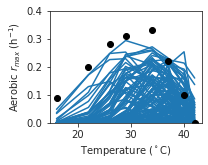

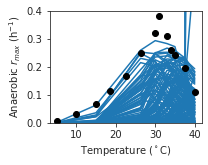

4.260765416666666
139


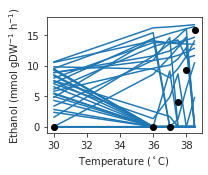

('unpermuted', 'replicate')
0.0018241406250000005


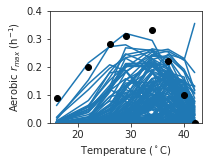

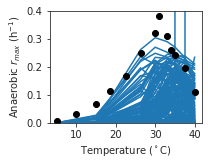

4.260765416666666
143


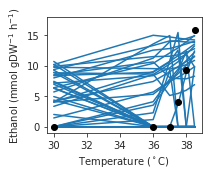

('permuted_0', 'original')
0.0018241406250000005


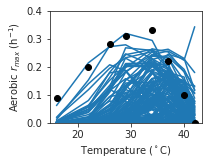

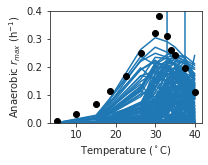

4.260765416666666
143


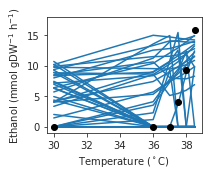

('permuted_0', 'replicate')
0.0018241406250000005


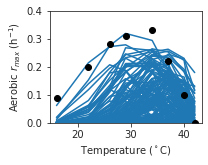

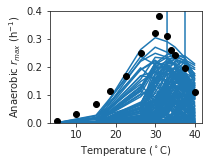

4.260765416666666
143


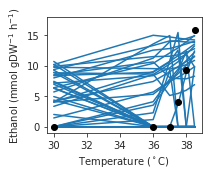

('permuted_1', 'original')
0.0018241406250000005


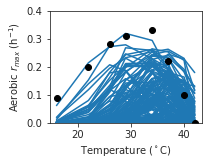

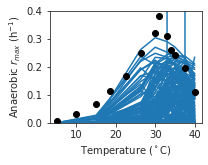

4.260765416666666
143


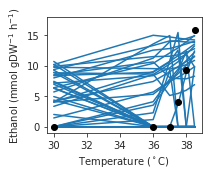

('permuted_1', 'replicate')
0.0018241406250000005


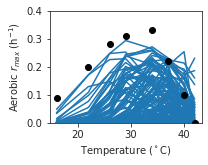

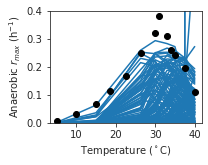

4.260765416666666
139


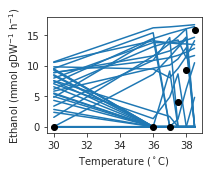

('permuted_2', 'original')
0.0018241406250000005


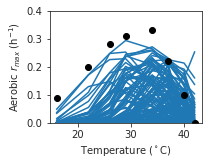

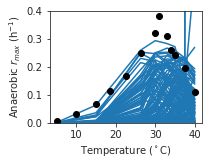

4.260765416666666
139


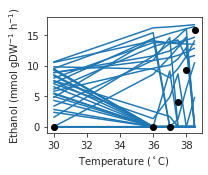

('permuted_2', 'replicate')
0.0018241406250000005


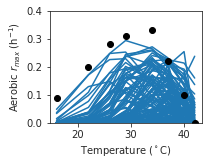

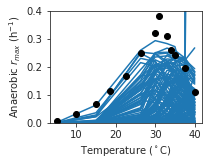

4.260765416666666
139


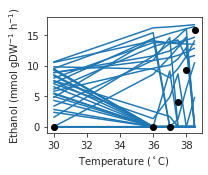

In [18]:
for index, model in models.iteritems():
    print(index)
    plot_lines_prior_ae(model)
    plot_lines_prior_an(model)
    plot_lines_prior_chemostat(model)

In [19]:
!pwd

/home/jakobpp/BayesianGEM/code


In [20]:
def plot_last_population_ae(model,outname=None):
    sns.set_style("ticks")
    plt.figure(figsize=(3,2.4))
    plt.scatter(dfae_batch.index,dfae_batch['r_ae'],color='k',label='experimental')
    print(np.var(dfae_batch['r_ae'])*0.15)
    
    rs0 = list()
    rs  = list()
    for item in model.simulated_data_t0: rs0.append(item['rae'])
    for item in model.simulated_data: rs.append(item['rae'])

    rs0 = np.array(rs0)
    y0 = np.percentile(rs0,[5,50,95],axis=0)
    
    rs = np.array(rs)
    y = np.percentile(rs,[5,50,95],axis=0)
    
    
    plt.plot(dfae_batch.index,y0[1,:],color='#1f78b4',label='prior')
    plt.fill_between(dfae_batch.index,y0[0,:],y0[2,:],alpha=0.8,color='#1f78b4')
    
    plt.plot(dfae_batch.index,y[1,:],color='#fc8d59',label='posterior')
    plt.fill_between(dfae_batch.index,y[0,:],y[2,:],alpha=0.8,color='#fc8d59')
    
    
    plt.xlabel('Temperature ($^\circ$C)')
    #plt.ylabel('Maximal specific growth rate (h$^{-1}$)')
    plt.ylabel('Aerobic $r_{max}$ (h$^{-1}$)')
    plt.ylim((0,0.4))
    #plt.legend(loc='upper left',fontsize=8)
    #plt.title('Aerobic growth')
    plt.tight_layout()
    if outname is not None: plt.savefig(outname)
    plt.show()

In [21]:
def plot_last_population_an(model,outname=None):
    sns.set_style("ticks")
    plt.figure(figsize=(3,2.4))
    plt.scatter(dfan_batch.index,dfan_batch['r_an'],color='k',label='experimental')
    
    
    rs0 = list() # prior
    rs = list()  # posterior
    for item in model.simulated_data: rs.append(item['ran'])
    for item in model.simulated_data_t0:rs0.append(item['ran'])
    ts = [5.0,15.0,26.3,30.0,33.0,35.0,37.5,40.0]
    print(np.var(dfan_batch.loc[ts,'r_an'])*0.15)
    
    rs0 = np.array(rs0)
    y0 = np.percentile(rs0,[5,50,95],axis=0)
    
    rs = np.array(rs)
    y = np.percentile(rs,[5,50,95],axis=0)
    
    plt.plot(ts,y0[1,:],color='#1f78b4',label='prior')
    plt.fill_between(ts,y0[0,:],y0[2,:],alpha=0.8,color='#1f78b4')
    
    plt.plot(ts,y[1,:],color='#fc8d59',label='posterior')
    plt.fill_between(ts,y[0,:],y[2,:],alpha=0.8,color='#fc8d59')
    
    plt.xlabel('Temperature ($^\circ$C)')
    #plt.ylabel('Maximal specific growth rate (h$^{-1}$)')
    plt.ylabel('Anaerobic $r_{max}$ (h$^{-1}$)')
    #plt.ylim((0,0.4))
    #plt.legend(loc='upper left',fontsize=8)
    #plt.title('Anaerobic growth')
    plt.tight_layout()
    if outname is not None: plt.savefig(outname)
    plt.show()

In [22]:
def plot_last_population_chemostat(model,prefix=None):
    sns.set_style("ticks")
    
    rs0 = []
    rs  = []
    for item in model.simulated_data_t0: rs0.append(item['chemostat'])
    for item in model.simulated_data: rs.append(item['chemostat'])

    #rs0 = np.array(rs0)
    #yt0 = np.mean(rs0,axis=0)
    #yerrt0 = np.std(rs0,axis=0)
    
    #rs = np.array(rs)
    #yt = np.mean(rs,axis=0)
    #yerrt = np.std(rs,axis=0)
    rs0 = np.array(rs0)
    yt0 = np.percentile(rs0,[5,50,95],axis=0)
    
    rs = np.array(rs)
    yt = np.percentile(rs,[5,50,95],axis=0)
    
    cols = ['Glucose','CO2','Ethanol']
    titles = ['Glucose','CO$_2$','Ethanol']
    print(np.var(dfchemo[cols].values)*0.15)
    for i in range(3):
        plt.figure(figsize=(3,2.4))
        plt.scatter(dfchemo.index,dfchemo[cols[i]],color='k',label='experimental')
        y0 = yt0[:,i*6:(i+1)*6]
        #yerr0 = yerrt0[i*6:(i+1)*6]
        plt.plot(dfchemo.index,y0[1,:],color='#1f78b4',label='prior')
        plt.fill_between(dfchemo.index,y0[0,:],y0[2,:],alpha=0.8,color='#1f78b4')
        
        y = yt[:,i*6:(i+1)*6]
        #yerr = yerrt[i*6:(i+1)*6]
        plt.plot(dfchemo.index,y[1,:],color='#fc8d59',label='posterior')
        plt.fill_between(dfchemo.index,y[0,:],y[2,:],alpha=0.8,color='#fc8d59')
        
        plt.xlabel('Temperature ($^\circ$C)')
        plt.ylabel('{0}'.format(titles[i])+' (mmol gDW$^{-1}$ h$^{-1}$)')
        plt.ylim((-1,18))
        #plt.legend(loc='upper left',fontsize=8)
        #plt.title(titles[i])
        plt.tight_layout()
        if prefix is not None: plt.savefig(prefix+'_{0}.pdf'.format(cols[i]))
        plt.show()

In [23]:
def plot_legend_growth():
    plt.figure(figsize=(3,2.4))
    plt.scatter([],[],color='k',label='Exp')
    
    plt.plot([],[],color='#1f78b4',label='Prior')
    plt.fill_between([],[],[],alpha=0.8,color='#1f78b4')
    
    plt.plot([],[],color='#fc8d59',label='Posterior')
    plt.fill_between([],[],[],alpha=0.8,color='#fc8d59')
    
    plt.legend(loc='center')
    plt.axis('off')
    plt.tight_layout()
    plt.savefig('../figures/prior_posterior_legend.pdf',transparent=True)
    plt.show()

('unpermuted', 'original')
0.0018241406250000005


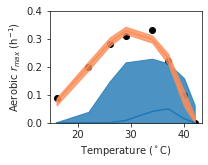

0.0017126156249999997


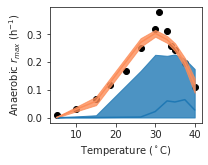

4.260765416666666


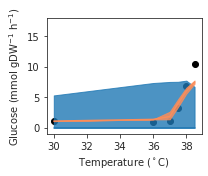

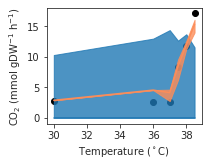

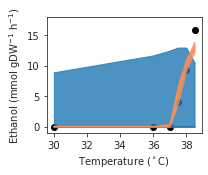

('unpermuted', 'replicate')
0.0018241406250000005


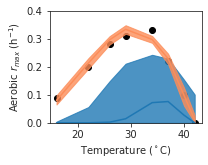

0.0017126156249999997


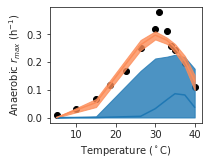

4.260765416666666


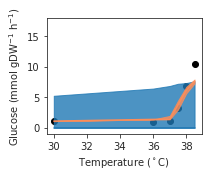

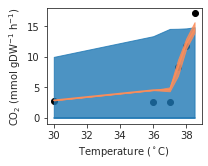

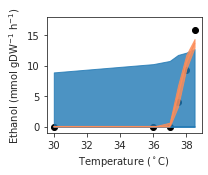

('permuted_0', 'original')
0.0018241406250000005


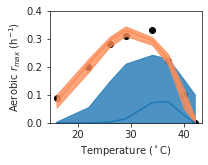

0.0017126156249999997


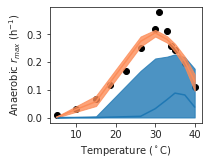

4.260765416666666


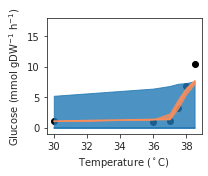

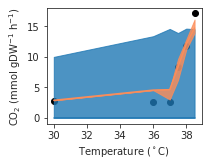

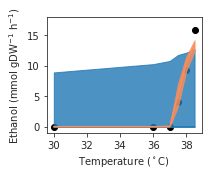

('permuted_0', 'replicate')
0.0018241406250000005


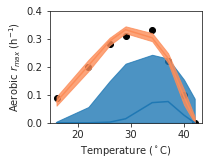

0.0017126156249999997


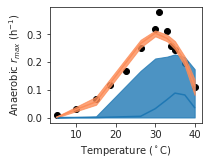

4.260765416666666


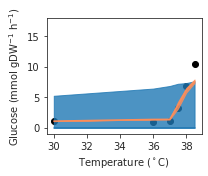

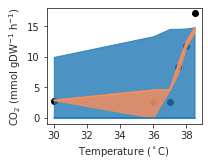

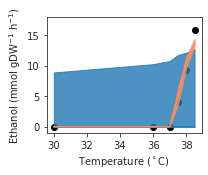

('permuted_1', 'original')
0.0018241406250000005


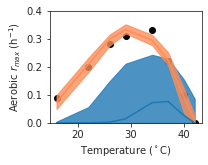

0.0017126156249999997


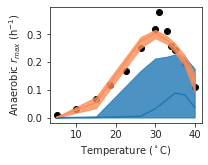

4.260765416666666


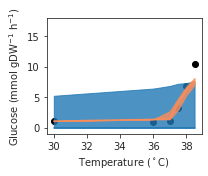

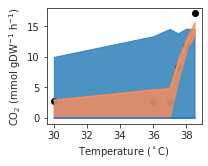

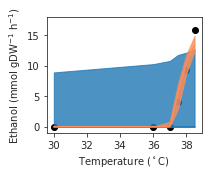

('permuted_1', 'replicate')
0.0018241406250000005


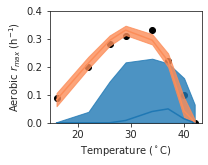

0.0017126156249999997


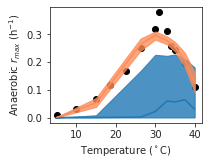

4.260765416666666


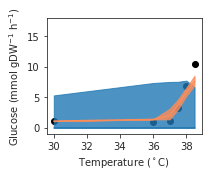

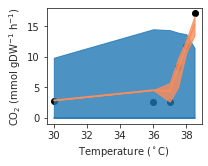

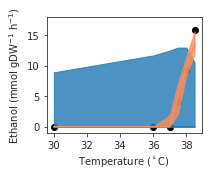

('permuted_2', 'original')
0.0018241406250000005


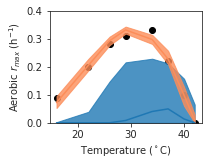

0.0017126156249999997


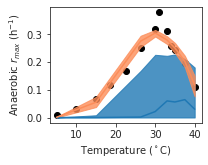

4.260765416666666


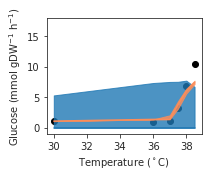

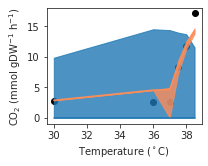

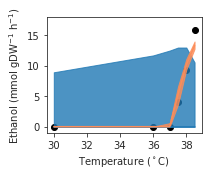

('permuted_2', 'replicate')
0.0018241406250000005


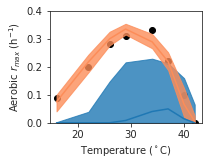

0.0017126156249999997


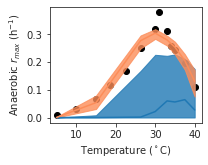

4.260765416666666


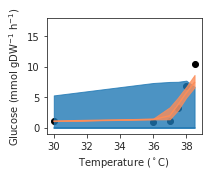

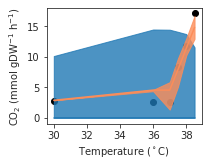

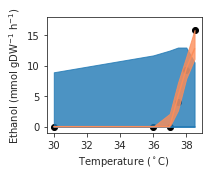

In [24]:
for index, model in models.iteritems():
    print(index)
    plot_last_population_ae(model)
    plot_last_population_an(model)
    plot_last_population_chemostat(model)
    

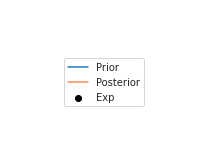

In [25]:
 plot_legend_growth()

### Visualize particle population

In [229]:
def build_a_dataframe_for_all_particles(results, n_priors = 128, r2_threshold = 0.9):
    columns = list(results.all_particles[0].keys())
    columns.sort()
    print("Iterating over particles")
    data = list()
    for p in results.all_particles:
        data.append([p[k] for k in columns])
    print("Creating Data Frame")
    df = pd.DataFrame(data=data,columns=columns)
    df['r2'] = results.all_distances
    print(df.shape)
    
    # Remove samples with a R2 score smaller than -3
    print("Doing filtering and labelling of Data Frame")
    df['r2'] = -df['r2']
    sel_index = df.index[df['r2']>-3]    
    df = df.loc[sel_index,:]
    df["period"] = "Intermediate"
    df.loc[:n_priors,"period"] = "Prior"
    df.loc[df["r2"] > r2_threshold,"period"] = 'Posterior'
    print(df.shape)

    return df

In [ ]:
model_frame["particle_df"] = load_pickle("../results/permuted_smcabc_res/particle_df.pkl")

In [ ]:
# Saving modeling frame for offloading computations to external script
dump_pickle(model_frame,"../results/permuted_smcabc_res/result_model_frame.pkl")

In [66]:
unique_origins = model_frame.index.get_level_values("origin").unique()

Index(['unpermuted', 'permuted_0', 'permuted_1', 'permuted_2'], dtype='object', name='origin')

In [291]:
combined_df = load_pickle("../results/permuted_smcabc_res/combined_particle_df.pkl")

In [292]:
pca_ordination = load_pickle("../results/permuted_smcabc_res/pca_full_ordination.pkl")

(70962,)
(70772,)
(71283,)
(71050,)
(70681,)
(71118,)
(63358,)
(63431,)


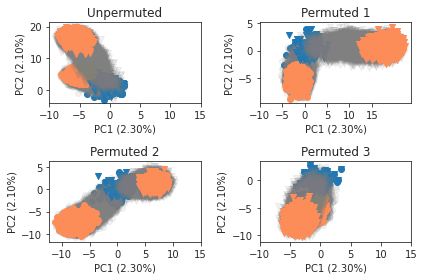

In [313]:
i=1
plt.figure()
figsize=(3.,2.4)
proper_names = {'unpermuted': "Unpermuted", 'permuted_0': "Permuted 1",
                'permuted_1': "Permuted 2", 'permuted_2': "Permuted 3"}
marker_dict = {'original': 'o', 'replicate': "v"}
all_periods = ["Prior", "Intermediate", 'Posterior']
period = combined_df["period"].to_numpy()
prior = combined_df["origin"].to_numpy()
model = combined_df["status"].to_numpy()
period_idxs = {period_name: np.nonzero(period == period_name)[0] for period_name in all_periods}
PCS, EV = pca_ordination
for origin in proper_names.keys():
    plt.subplot(2,2,i)
    for label in ['original', 'replicate']:
        label_idxs = np.nonzero((model == label) & (prior == origin))[0]
        marker = marker_dict[label]
        this_idxs = {period: np.intersect1d(period_idxs[period], label_idxs) for period in all_periods}
        print(label_idxs.shape)
        # plt.scatter(PCS[:,0],PCS[:,1],color='grey',alpha=0.2)
        # prior_idxs = np.intersect1d(label_idxs, period_idxs["prior"])
        plt.scatter(PCS[this_idxs['Prior'],0],PCS[this_idxs['Prior'], 1],color='#1f78b4',label='Prior', marker=marker)
        plt.scatter(PCS[this_idxs["Intermediate"],0],PCS[this_idxs["Intermediate"], 1],
                    color='grey',alpha=0.1,label='Intermediate',marker=marker)
        plt.scatter(PCS[this_idxs['Posterior'],0],PCS[this_idxs['Posterior'], 1],
                    color='#fc8d59',label='Posterior',marker=marker)
    i += 1
    plt.xlabel('PC1 ({:.2f}%)'.format(EV[0]*100))
    plt.ylabel('PC2 ({:.2f}%)'.format(EV[1]*100))
    plt.xticks(np.arange(-10,20,5))
    plt.title(proper_names[origin])
    plt.tight_layout()
plt.savefig("../figures/pca.png",dpi=300)
plt.show()

## $R^2$ convergence plots

In [26]:
def r2_on_data(Yobs, simulated_data_one):
    r2_diff_dbs = [r2_score(Yobs[db],simulated_data_one[db]) for db in Yobs]
    return np.mean(r2_diff_dbs)

In [27]:
Yobs_batch = GEMS.aerobic_exp_data()
Yobs_chemo = GEMS.chemostat_exp_data()
#Yobs_batch_an = GEMS.anaerobic_exp_data()
dfae_batch,dfan_batch =GEMS.load_exp_batch_data('../data/ExpGrowth.tsv')
sel_temp = [5.0,15.0,26.3,30.0,33.0,35.0,37.5,40.0]
Yobs_batch_an = {'data':dfan_batch.loc[sel_temp,'r_an'].values}

Yobs = {'rae':Yobs_batch['data'],
        'chemostat':Yobs_chemo['data'],
        'ran':Yobs_batch_an['data']}

In [28]:
def plot_convergence_inner(model, maxiter, offset = 128, generation_size = 100, ind_start = 0, label = None):
    # Offset: Number of newly generated particles per generation
    r2s = []
    ind = ind_start
    i = 0
    # This is a cleaver trick to avoid redoing calculations for every iterations which
    # turns out to be very time-consuming.
    # r2s_history = np.array([r2_on_data(Yobs, item) if item is not None else 0 for
    #                         item in model.all_simulated_data[:offset*maxiter]])
    r2s_history = -np.array(model.all_distances[:offset*maxiter]])
    r2s_history_argsorted = np.argsort(r2s_history)
    while ind < len(model.all_simulated_data):
        i += 1
        if i > maxiter:
            break
        # This is a mask ensuring data created after the interation are excluded
        filter_mask = r2s_history_argsorted < ind + offset
        r2s_now = r2s_history[r2s_history_argsorted[filter_mask]][-generation_size:]
        r2s.append(r2s_now)
        ind += offset
    y = np.array(r2s)
    yp = np.percentile(y,[5,50,95],axis=1)
    plt.plot(np.arange(len(r2s)),yp[1,:], label = label)
    plt.fill_between(np.arange(len(r2s)),yp[0,:],yp[2,:],alpha=0.5)

In [29]:
def plot_convergence(model, maxiter=100):
    plt.figure(figsize=(3,2.4))
    plot_convergence_inner(model,maxiter)
    plt.ylim([0,1])
    plt.xlabel('Iterations')
    plt.ylabel('$R^2$')
    plt.tight_layout()
    plt.show()

In [30]:
def plot_convergence_and_compare(model, reference_model, maxiter=500, legend = True):
    plt.figure(figsize=(3,2.4))
    plot_convergence_inner(model,maxiter, label = 'Original')
    plot_convergence_inner(reference_model,maxiter, label = 'Replicate')
    plt.ylim([0,1])
    plt.xlabel('Iterations')
    plt.ylabel('$R^2$')
    if legend:plt.legend()
    plt.tight_layout()
    plt.show()

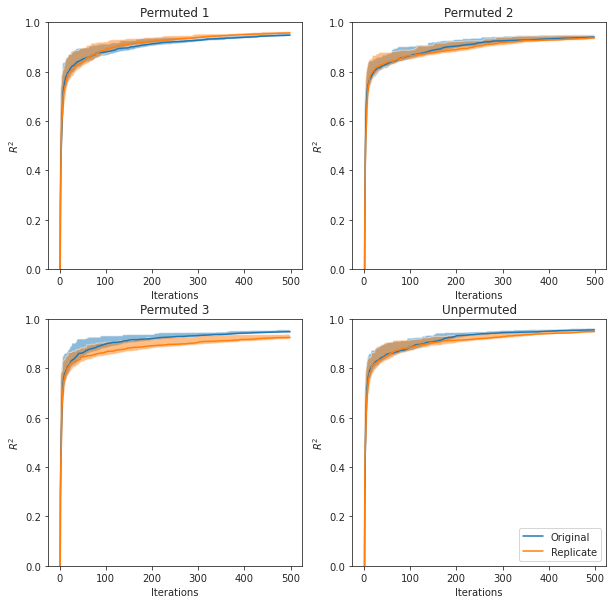

In [32]:
proper_names = {'unpermuted': "Unpermuted", 'permuted_0': "Permuted 1",
                'permuted_1': "Permuted 2", 'permuted_2': "Permuted 3"}
maxiter = 500
i = 1
plt.figure(figsize=(10,10))
for index, series in model_frame["model"].groupby("origin"):
    plt.subplot(2,2,i)
    models = series[index]
    original_model = models["original"]
    replicate_model = models["replicate"]
    plot_convergence_inner(original_model,maxiter, label = 'Original')
    plot_convergence_inner(replicate_model,maxiter, label = 'Replicate')
    if i==4:
        plt.legend()
    plt.ylim([0,1])
    plt.xlabel('Iterations')
    plt.ylabel('$R^2$')
    plt.title(proper_names[index])
    i += 1
plt.savefig("../figures/R2.pdf")
plt.show()

# Bayesian interpolation experiments

In [75]:
simulator = GEMS.simulate_at_three_conditions_2
distance_function = GEMS.distance_2
Yobs_batch = GEMS.aerobic_exp_data()
Yobs_chemo = GEMS.chemostat_exp_data()
#Yobs_batch_an = GEMS.anaerobic_exp_data()
dfae_batch,dfan_batch =GEMS.load_exp_batch_data('../data/ExpGrowth.tsv')
sel_temp = [5.0,15.0,26.3,30.0,33.0,35.0,37.5,40.0]
Yobs_batch_an = {'data':dfan_batch.loc[sel_temp,'r_an'].values}
Yobs = {'rae':Yobs_batch['data'],
        'chemostat':Yobs_chemo['data'],
        'ran':Yobs_batch_an['data']}


In [78]:
model_idx = 4
particle_idx = 2095
particle = model_frame["model"][model_idx].all_particles[particle_idx]
true_sim_res = model_frame["model"][model_idx].all_simulated_data[particle_idx]
distance = model_frame["model"][model_idx].all_particles[particle_idx]

In [82]:
true_sim_res

{'rae': array([0.10612665, 0.26097539, 0.32353074, 0.34325299, 0.2923598 ,
        0.24378221, 0.08196635, 0.        ]),
 'chemostat': array([ 1.07734354,  3.8149469 ,  4.8636373 ,  5.38154829,  5.89573594,
         6.44641691,  0.        ,  0.        ,  0.        ,  7.09966075,
        11.82333887, 12.69822574,  0.        ,  1.1277452 ,  4.68346713,
         8.83214563,  9.96586631, 11.18046579]),
 'ran': array([0.00143893, 0.07675257, 0.28640146, 0.30916752, 0.2898344 ,
        0.27100147, 0.23996361, 0.15674638])}

In [80]:
sim_res = simulator(particle)

16.0 0.10612665134835214
22.0 0.26097539433601447
26.0 0.32353073864832954
29.0 0.3432529922966316
34.0 0.2923597991572564
37.0 0.24378221197088765
40.0 0.081966352204659
42.0 0.000619745589544014
5.0 0.0014389328439695062
15.0 0.07675256854959978
26.30000000000001 0.2864014579512019
30.0 0.3091675174205013
33.0 0.2898344044083819
35.0 0.2710014743473208
37.5 0.23996360546200174
40.0 0.15674638233915833


In [81]:
sim_res

{'rae': array([0.10612665, 0.26097539, 0.32353074, 0.34325299, 0.2923598 ,
        0.24378221, 0.08196635, 0.        ]),
 'chemostat': array([ 1.07734354,  3.81494657,  4.86363702,  5.38154803,  5.89573571,
         6.4464167 ,  2.84471709,  0.        ,  0.        ,  7.09966018,
         8.23326349, 12.69822541,  0.        ,  1.12774403,  4.68346614,
         8.83214506,  9.96586579, 11.18046532]),
 'ran': array([0.00143893, 0.07675257, 0.28640146, 0.30916752, 0.2898344 ,
        0.27100147, 0.23996361, 0.15674638])}

In [60]:
for label, model in model_frame["model"].iteritems():
    print(f"{label}: {len(model.all_distances)}")

('unpermuted', 'original'): 70000
('unpermuted', 'replicate'): 72000
('permuted_0', 'original'): 72000
('permuted_0', 'replicate'): 72000
('permuted_1', 'original'): 72000
('permuted_1', 'replicate'): 70000
('permuted_2', 'original'): 70000
('permuted_2', 'replicate'): 70000


In [69]:
for model in model_frame["model"]: 
    print(np.nonzero([x is None for x in model.all_simulated_data]))

(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)


In [63]:
for label, model in model_frame["model"].iteritems():
    print(f"{label}: {len(model.all_simulated_data)}")

('unpermuted', 'original'): 70000
('unpermuted', 'replicate'): 72000
('permuted_0', 'original'): 72000
('permuted_0', 'replicate'): 72000
('permuted_1', 'original'): 72000
('permuted_1', 'replicate'): 70000
('permuted_2', 'original'): 70000
('permuted_2', 'replicate'): 70000


In [64]:
72000/ 500

144.0

In [33]:
bayesian_interpolation_results = load_pickle("../results/permuted_smcabc_res/bayesian_interpolation_results.pkl")

In [34]:
bayesian_interpolation_results["from_origin"] = [x[0] for x in bayesian_interpolation_results["from"]]
bayesian_interpolation_results["from_status"] = [x[1] for x in bayesian_interpolation_results["from"]]
bayesian_interpolation_results["to_origin"] = [x[0] for x in bayesian_interpolation_results["to"]]
bayesian_interpolation_results["to_status"] = [x[1] for x in bayesian_interpolation_results["to"]]
del bayesian_interpolation_results["from"]
del bayesian_interpolation_results["to"]

In [35]:
bayesian_interpolation_results.columns

Index(['results', 'from_origin', 'from_status', 'to_origin', 'to_status'], dtype='object')

In [36]:
intra_interpolation_results = bayesian_interpolation_results.query("from_origin == to_origin")

In [37]:
intra_interpolation_results[["from_origin", "from_status", "to_origin", "to_status"]]

,from_origin,from_status,to_origin,to_status
0,unpermuted,original,unpermuted,replicate
13,permuted_0,original,permuted_0,replicate
22,permuted_1,original,permuted_1,replicate
27,permuted_2,original,permuted_2,replicate


In [38]:
intra_interpolation = (intra_interpolation_results["results"].
set_axis(intra_interpolation_results["from_origin"])
                      )

In [39]:
inter_interpolation_results = (bayesian_interpolation_results.
query("(from_status == 'original') & (to_status == 'original')")
                              )

In [40]:
inter_interpolation_results[["from_origin", "from_status", "to_origin", "to_status"]]

,from_origin,from_status,to_origin,to_status
1,unpermuted,original,permuted_0,original
3,unpermuted,original,permuted_1,original
5,unpermuted,original,permuted_2,original
14,permuted_0,original,permuted_1,original
16,permuted_0,original,permuted_2,original
23,permuted_1,original,permuted_2,original


In [46]:
inter_interpolation = (inter_interpolation_results["results"].
set_axis(zip(inter_interpolation_results["from_origin"], inter_interpolation_results["to_origin"]))
                      )

In [47]:
inter_interpolation.index

Index([('unpermuted', 'permuted_0'), ('unpermuted', 'permuted_1'),
       ('unpermuted', 'permuted_2'), ('permuted_0', 'permuted_1'),
       ('permuted_0', 'permuted_2'), ('permuted_1', 'permuted_2')],
      dtype='object')

In [56]:
inter_color_dict = {origin_pair: plt.cm.Set1(i) for i, origin_pair in enumerate(inter_interpolation.index)}

In [57]:
intra_color_dict = {origin: plt.cm.Set1(i) for i, origin in enumerate(intra_linestyle_dict.keys())}

In [49]:
plt.cm.Set1(6)

(0.6509803921568628, 0.33725490196078434, 0.1568627450980392, 1.0)

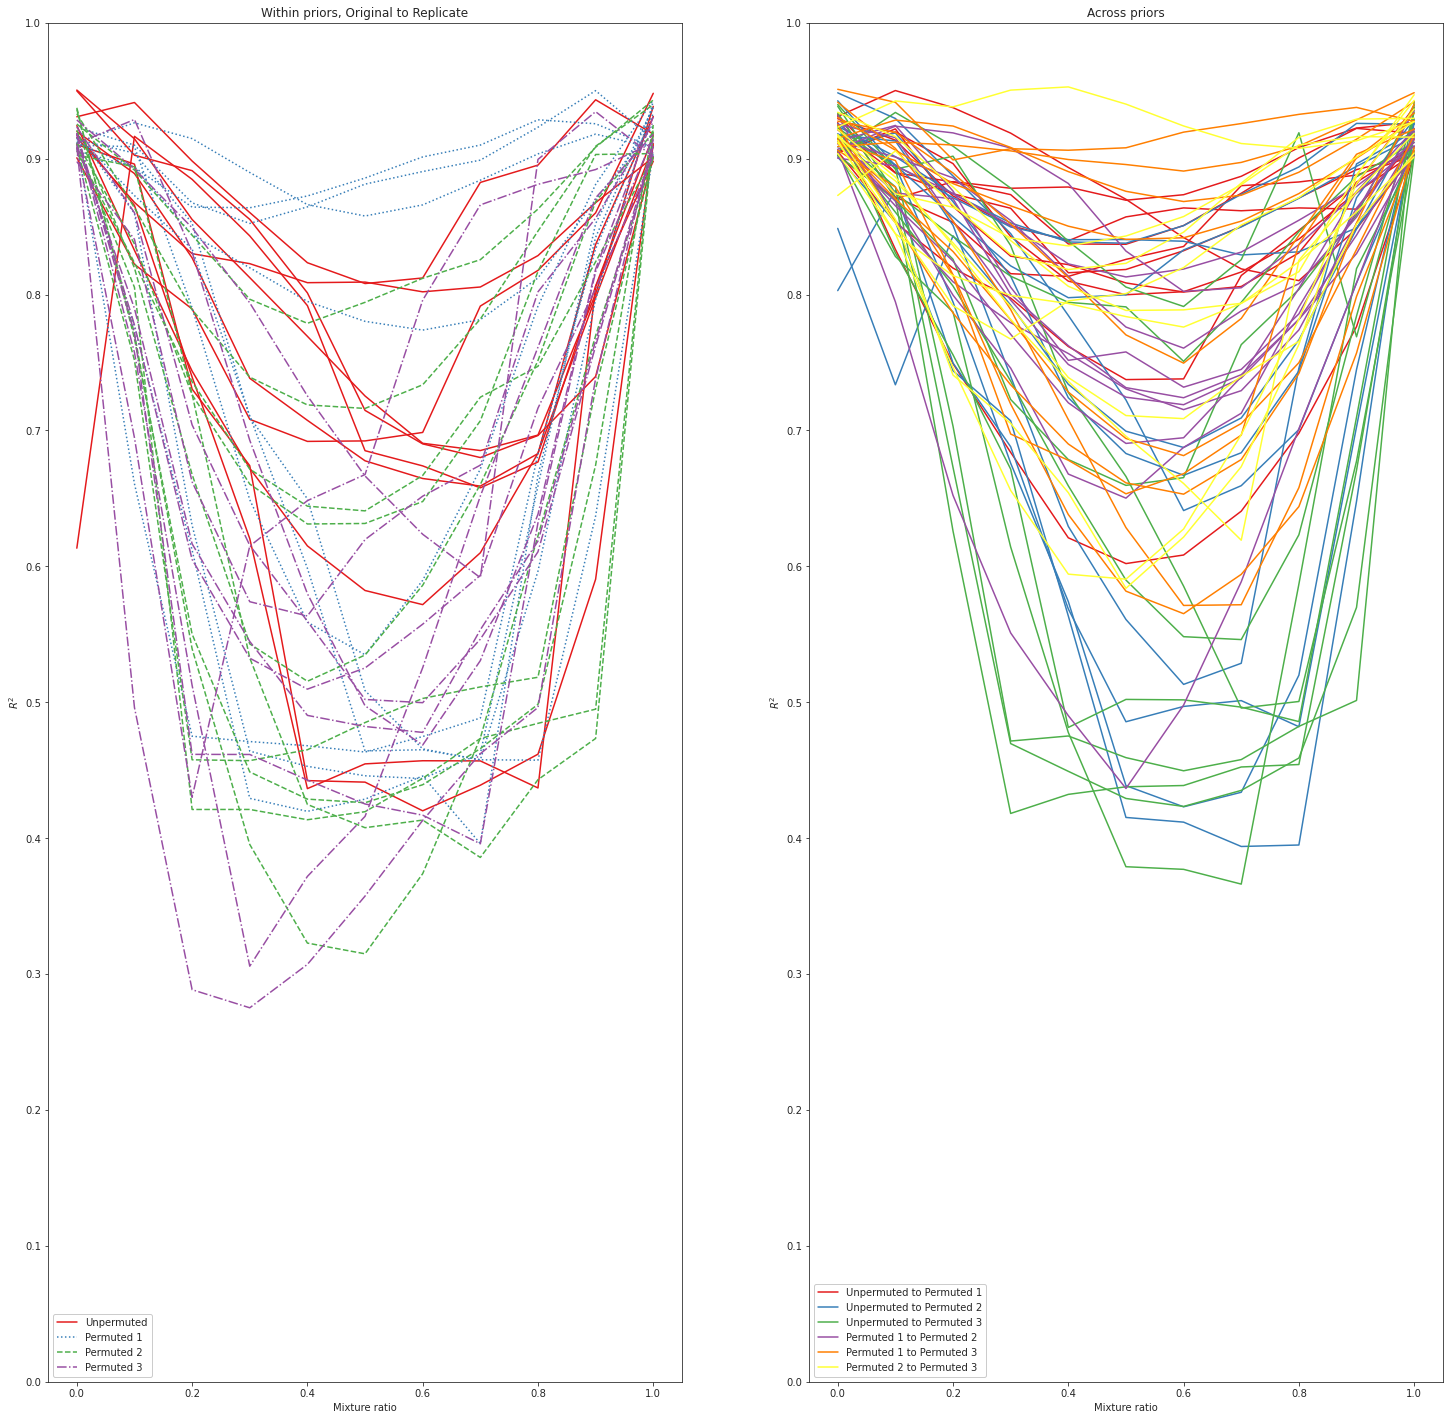

In [51]:
proper_names = {'unpermuted': "Unpermuted", 'permuted_0': "Permuted 1",
                'permuted_1': "Permuted 2", 'permuted_2': "Permuted 3"}
plt.figure(figsize=(25,25))
intra_linestyle_dict = {"unpermuted": "solid", "permuted_0": "dotted", "permuted_1": "dashed", "permuted_2": "dashdot"}
intra_color_dict = {origin: plt.cm.Set1(i) for i, origin in enumerate(intra_linestyle_dict.keys())}
plt.subplot(1,2,1)
for origin, results in intra_interpolation.iteritems():
    for result in results:
        plt.plot(result['ratio'],-result['distances'],linestyle = intra_linestyle_dict[origin],
                 color=intra_color_dict[origin],label = origin)
        plt.xlabel('Mixture ratio')
        plt.ylabel('$R^2$')
        plt.ylim([0,1])
f = lambda l,c, label: plt.plot([],[],linestyle=l, color=c, label=label)[0]
handles = [f(l=intra_linestyle_dict[origin], c=intra_color_dict[origin], label = proper_names[origin]) 
           for origin in intra_linestyle_dict.keys()]
plt.legend(handles=handles, loc=3, framealpha=1)
plt.yticks(np.arange(0,1.1,0.1))
plt.title("Within priors, Original to Replicate")
#####
plt.subplot(1,2,2)
for origin_pair, results in inter_interpolation.iteritems():
    for result in results:
        plt.plot(result['ratio'],-result['distances'], color=inter_color_dict[origin_pair])
        plt.xlabel('Mixture ratio')
        plt.ylabel('$R^2$')
        plt.ylim([0,1])
f = lambda c, label: plt.plot([],[], color=c, label=label)[0]
def inter_labelmaker(origin_pair):
    from_origin = origin_pair[0]
    to_origin = origin_pair[1]
    return f"{proper_names[from_origin]} to {proper_names[to_origin]}"
handles = [f(c=inter_color_dict[origin_pair], label = inter_labelmaker(origin_pair))
           for origin_pair in inter_color_dict.keys()]
plt.legend(handles=handles, loc=3, framealpha=1)
plt.yticks(np.arange(0,1.1,0.1))
plt.title("Across priors")
plt.savefig("../figures/bayesian_interpolation.pdf")
plt.show()

In [52]:
proper_names

{'unpermuted': 'Unpermuted',
 'permuted_0': 'Permuted 1',
 'permuted_1': 'Permuted 2',
 'permuted_2': 'Permuted 3'}

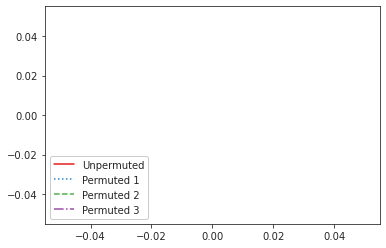

In [53]:
f = lambda l,c, label: plt.plot([],[],linestyle=l, color=c, label=label)[0]
handles = [f(l=intra_linestyle_dict[origin], c=intra_color_dict[origin], label = proper_names[origin]) 
           for origin in intra_linestyle_dict.keys()]
plt.legend(handles=handles, loc=3, framealpha=1)

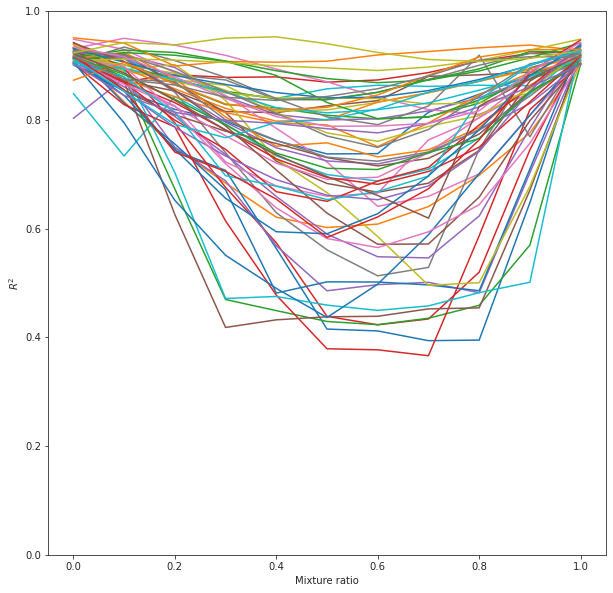

In [54]:
plt.figure(figsize=(10,10))
linestyle_dict = {"unpermuted": "solid", "permuted_0": "dotted", "permuted_1": "dashed", "permuted_2": "dashdot"}
for _, results in inter_interpolation.iteritems():
    for result in results:
        plt.plot(result['ratio'],-result['distances'])
        plt.xlabel('Mixture ratio')
        plt.ylabel('$R^2$')
        plt.ylim([0,1])
plt.show()

Please observe: The consensus solution is not neccessarily a good one even though it is an average of better solutions.

# Results of evolutionary algorithm

In [50]:
evolution_model = pickle.load(open('../results/smcevo_gem_three_conditions_save_all_particles.pkl','rb'))

In [55]:
evolution_model.generation_size

100

In [56]:
evolution_model.generations

134

In [57]:
len(evolution_model.population)

134

In [60]:
list(map(len,evolution_model.population))[0:10]

[100, 100, 100, 100, 100, 100, 100, 100, 100, 100]

In [61]:
len(evolution_model.all_particles)

6750

In [68]:
(len(evolution_model.all_particles) - 50) / evolution_model.generations # 50 new children per generations

50.0

In [67]:
len(evolution_model.all_particles) % evolution_model.generations

50

In [233]:
evolution_model.generations

134

In [64]:
type(evolution_model.all_particles[0])

dict

In [227]:
def plot_convergence_and_compare_evolution(model, reference_model, maxiter=100, legend = True):
    plot_convergence_inner(model, offset=50, generation_size=100, maxiter=maxiter, ind_start = 50, label = 'Evolutionary')
    plot_convergence_inner(reference_model, maxiter=maxiter, label = 'Bayesian')
    plt.ylim([0,1])
    plt.xlabel('Iterations')
    plt.ylabel('$R^2$')
    if legend:plt.legend(loc="lower right")
    plt.tight_layout()
    return fig

In [72]:
evolution_model

In [73]:
reference_model

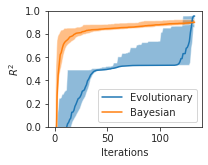

In [228]:
fig = plt.figure(figsize=(3,2.4))
evo_convergence_figure = plot_convergence_and_compare_evolution(evolution_model, reference_model, maxiter = evolution_model.generations)
plt.savefig("evo_fig.pdf")

# Effects on pathway level

In [192]:
combined_list = [reference_model]
combined_list.extend(models)
combined_index = ['unpermuted']
combined_index.extend((f'permuted_{i}') for i in range(3))
combined_df = pd.DataFrame({'model' : combined_list},index=combined_index)

In [42]:
combined_df

,model
unpermuted,<abc_etc.SMCABC object at 0x7fb6b230e9a0>
permuted_0,<abc_etc.SMCABC object at 0x7fb7365c6ca0>
permuted_1,<abc_etc.SMCABC object at 0x7fb76c0b8250>
permuted_2,<abc_etc.SMCABC object at 0x7fb73649f280>
